# 3D MHD Example : Orszag Tang Vortex

In this notebook, we will reproduce the Orszag Tang Vortex using MHDFlows. We follow the setup from  [Morales et al. 2014](http://dx.doi.org/10.1016/j.jcp.2014.05.038) Section 6.1

In [1]:
using MHDFlows
using CUDA
using PyPlot
using HDF5,FFTW
using LinearAlgebra: mul!, ldiv!
using Statistics

┌ Info: Precompiling MHDFlows [top-level]
└ @ Base loading.jl:1664
[ Info: FourierFlows will use 8 threads
┌ Info: FourierFlows will use 8 threads
└ @ FourierFlows /mnt/d/julialib/FourierFlows.jl_myfork/src/FourierFlows.jl:116


In [ ]:
device!(0)
device()

In [2]:
function ProblemGeneratorOhm!(prob;L0=2π,β = 0.8)
  # Output Setting  
  x = Array(prob.grid.x);
  y = Array(prob.grid.y);
  z = Array(prob.grid.z);
  T = eltype(prob.grid);
  nx,ny,nz = prob.grid.nx,prob.grid.ny,prob.grid.nz;
  @devzeros typeof(CPU()) T (nx,ny,nz) ux uy bx by bz

  for k = 1:nz::Int, j = 1:ny::Int
     @simd for i = 1:nx::Int
        ux[i,j,k] = -2*sin(y[j]);
        uy[i,j,k] =  2*sin(x[i]);
        bx[i,j,k] = β*(-2*sin(2y[j]) + sin(z[k]));
        by[i,j,k] = β*(2*sin(x[i]) + sin(z[k]));
        bz[i,j,k] = β*( sin(x[i]) + sin(y[j]));
     end
  end
  SetUpProblemIC!(prob; ux = ux, uy = uy,
                        bx = bx, by = by, bz = bz);
  return nothing  
end

ProblemGeneratorOhm! (generic function with 1 method)

In [3]:
#parameters
N =  128;
Nz=  128;#div(N,32);
Lx = 2π;
ν,η = 0.005,0.005;
dt  = 2.5e-3;
# Testing the problem 
nothingfunction(args...) = nothing;
GPUprob = Problem(GPU();
        # Numerical parameters
                      nx = N,
                      Lx = Lx,
                      ny = N,
                      nz = Nz,
         # Drag and/or hyper-viscosity for velocity/B-field
                       ν = ν,
                      nν = 1,
                       η = η,
        # B-field & VP method
                 B_field = true,
               VP_method = false,
        # Timestepper and equation options
                      dt = dt,
                 stepper = "RK4",
        # Force Driving parameters       
                   calcF = nothingfunction,
        # Float type and dealiasing
                       T = Float32)

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: ON
  ├─────├────── VP Method: OFF
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on GPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

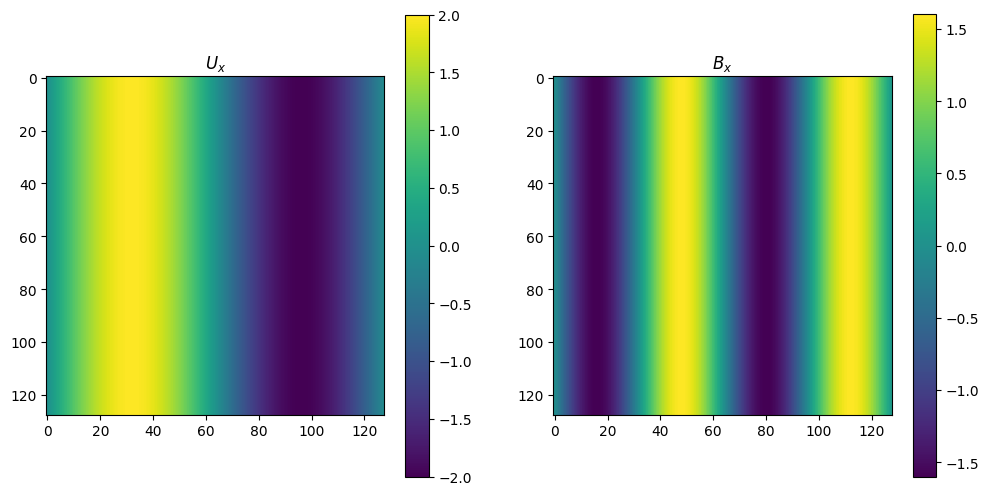

PyObject <matplotlib.colorbar.Colorbar object at 0x7fea99544a90>

In [4]:
ProblemGeneratorOhm!(GPUprob);
figure(figsize=(12,6))
subplot(121)
imshow(Array(GPUprob.vars.ux)[:,:,1])
title(L"U_x");
colorbar()

subplot(122)
imshow(Array(GPUprob.vars.bx)[:,:,1])
title(L"B_x");
colorbar()

In [5]:
function Getjmax(prob)
    bx,by,bz = prob.vars.bx,prob.vars.by,prob.vars.bz;
    j1,j2,j3 =  Curl(bx,by,bz,prob.grid);
    maxj = √(maximum(j1.^2 .+ j2.^2 .+ j3.^2));
    return maxj;
end
maxjs = MHDFlows.Diagnostic(Getjmax, GPUprob,freq=50);

In [6]:
GPUprob.clock.t = 0
@CUDA.time TimeIntegrator!(GPUprob, 5.0,50000;
                                   usr_dt = dt,
                                    diags = [maxjs],
                              loop_number = 100);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/doraho/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Simulation in rogress :   4%|▃         |  ETA: 0:16:20 (20.42 ms/it)
  Progress:    iter/Nₒ = 1997/50000, t/t₀ = 4.99/5.0
  Statistics:  KE = 246.0, ME = 413.0

Total CPU/GPU time run = 40.83 s, zone update per second = 1.02725000911e8 
 42.778270 seconds (87.95 M CPU allocations: 7.707 GiB, 3.21% gc time) (124.60 k GPU allocations: 922.077 GiB, 1.22% memmgmt time)


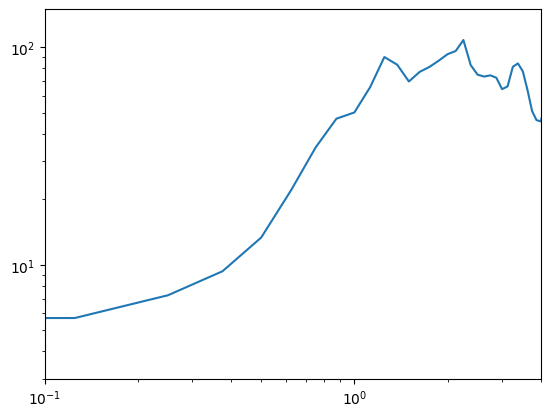

(3, 150)

In [7]:
n = maxjs.i;
t = maxjs.t[1:n];
j = maxjs.data[1:n];
plot(t,j)
loglog()
xlim(0.1,4)
ylim(3,150)

# $256^3$ Case

In [8]:
#parameters
N =  256;
Nz=  256;#div(N,32);
Lx = 2π;
ν,η = 0.001,0.001;
dt  = 2.5e-3;
# Testing the problem 
nothingfunction(args...) = nothing;
GPUprob = Problem(GPU();
        # Numerical parameters
                      nx = N,
                      Lx = Lx,
                      ny = N,
                      nz = Nz,
         # Drag and/or hyper-viscosity for velocity/B-field
                       ν = ν,
                      nν = 1,
                       η = η,
        # B-field & VP method
                 B_field = true,
               VP_method = false,
        # Timestepper and equation options
                      dt = dt,
                 stepper = "RK4",
        # Force Driving parameters       
                   calcF = nothingfunction,
        # Float type and dealiasing
                       T = Float32)

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: ON
  ├─────├────── VP Method: OFF
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on GPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [9]:
function Getjmax(prob)
    bx,by,bz = prob.vars.bx,prob.vars.by,prob.vars.bz;
    j1,j2,j3 =  Curl(bx,by,bz,prob.grid);
    maxj = √(maximum(j1.^2 .+ j2.^2 .+ j3.^2));
    return maxj;
end
maxjs2 = MHDFlows.Diagnostic(Getjmax, GPUprob,freq=50);

In [10]:
ProblemGeneratorOhm!(GPUprob);
@CUDA.time TimeIntegrator!(GPUprob, 5.0,50000;
                                   usr_dt = dt,
                                    diags = [maxjs2],
                              loop_number = 100);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/doraho/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Simulation in rogress :   4%|▃         |  ETA: 2:24:47 ( 0.18  s/it)
  Progress:    iter/Nₒ = 2000/50000, t/t₀ = 5.0/5.0
  Statistics:  KE = 287.0, ME = 553.0

Total CPU/GPU time run = 361.948 s, zone update per second = 9.2705091293e7 
361.948240 seconds (38.84 M CPU allocations: 5.266 GiB, 0.32% gc time) (124.60 k GPU allocations: 7.158 TiB, 10.54% memmgmt time)


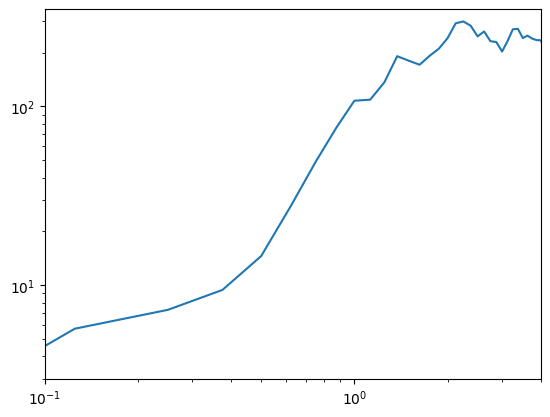

(3, 350)

In [11]:
n = maxjs2.i;
t = maxjs2.t[1:n];
j = maxjs2.data[1:n];
plot(t,j)
loglog()
xlim(0.1,4)
ylim(3,350)